note: ensure both endpoints are running

In [10]:
import boto3
import sagemaker
from sagemaker import Session
from sagemaker.tensorflow import TensorFlowModel, TensorFlowPredictor
import tensorflow
import s3fs
import numpy as np

RANDOM_SEED = 0
sagemaker.__version__
fs = s3fs.S3FileSystem()
sm = boto3.client("sagemaker")
sess = sagemaker.Session()
role = sagemaker.get_execution_role()
s3 = boto3.client("s3")
bucket = sess.default_bucket()   # will be sagemaker-ap-southeast-2-838084669510
prefix = "aiornot"
print(f"S3 Bucket: f{bucket}")


S3 Bucket: fsagemaker-ap-southeast-2-838084669510


# Start Endpoints

In [11]:
transfer_model_s3_path = "s3://sagemaker-ap-southeast-2-838084669510/model_output/transfer-learning-20250816-075841/output/model.tar.gz"
transfer_model = TensorFlowModel(
    model_data=transfer_model_s3_path,
    role=role,
    framework_version="2.14"
)

try:
    transfer_model_predictor = transfer_model.deploy(
        initial_instance_count=1,
        instance_type="ml.m5.large",
        endpoint_name="transfer-model-endpoint"
    )
except Exception: # has already been deployed, so just call the existing endpoint
    transfer_model_predictor = TensorFlowPredictor(
        endpoint_name="transfer-model-endpoint",
        sagemaker_session=sess
    )

In [12]:
main_model_s3_path = "s3://sagemaker-ap-southeast-2-838084669510/aiornot/model_output/bestparams-refit-20250816-094717/output/model.tar.gz"
main_model = TensorFlowModel(
    model_data=main_model_s3_path,
    role=role,
    framework_version="2.14"
)
try: # has not yet been deployed
    main_model_predictor = main_model.deploy(
        initial_instance_count=1,
        instance_type="ml.m5.large",
        endpoint_name="final-model-endpoint"
    )
except Exception: # has already been deployed, so just call the existing endpoint
    main_model_predictor = TensorFlowPredictor(
        endpoint_name="final-model-endpoint",
        sagemaker_session=sess
    )

# Make Predictions for both models

In [14]:
test_path = f"s3://{bucket}/{prefix}/holdout_test/holdout_test.npz"

with fs.open(test_path, "rb") as f:
    d = np.load(f)
    X = d["image"].astype("float32") 
    y_true = np.asarray(d["label"], dtype=int).ravel()
    print("data loaded")

def predict_batches(pred, X, bs=4):
    probs = []
    for i in range(0, len(X), bs):
        out = pred.predict(X[i:i+bs].tolist())
        p = np.array(out.get("predictions", out)).reshape(-1)  # shape (bs,)
        probs.append(p)
        print(f"{i}/{len(X)}")
    probs = np.concatenate(probs)
    predictions = (probs >= 0.5).astype(int)
    return predictions


y_test_main_model = predict_batches(main_model_predictor, X)
y_test_transfer_model = predict_batches(transfer_model_predictor, X)

data loaded
0/500
4/500
8/500
12/500
16/500
20/500
24/500
28/500
32/500
36/500
40/500
44/500
48/500
52/500
56/500
60/500
64/500
68/500
72/500
76/500
80/500
84/500
88/500
92/500
96/500
100/500
104/500
108/500
112/500
116/500
120/500
124/500
128/500
132/500
136/500
140/500
144/500
148/500
152/500
156/500
160/500
164/500
168/500
172/500
176/500
180/500
184/500
188/500
192/500
196/500
200/500
204/500
208/500
212/500
216/500
220/500
224/500
228/500
232/500
236/500
240/500
244/500
248/500
252/500
256/500
260/500
264/500
268/500
272/500
276/500
280/500
284/500
288/500
292/500
296/500
300/500
304/500
308/500
312/500
316/500
320/500
324/500
328/500
332/500
336/500
340/500
344/500
348/500
352/500
356/500
360/500
364/500
368/500
372/500
376/500
380/500
384/500
388/500
392/500
396/500
400/500
404/500
408/500
412/500
416/500
420/500
424/500
428/500
432/500
436/500
440/500
444/500
448/500
452/500
456/500
460/500
464/500
468/500
472/500
476/500
480/500
484/500
488/500
492/500
496/500
0/500
4/500
8/50

In [15]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


def get_metrics(y_pred):
    metrics = {
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "accuracy": accuracy_score(y_true, y_pred),
    }
    return metrics


main_metrics = get_metrics(y_test_main_model)
transfer_metrics = get_metrics(y_test_transfer_model)

# turn into dataframe
df = pd.DataFrame([
    {"name": "main model", **main_metrics},
    {"name": "transfer model", **transfer_metrics}
])
df

,name,precision,recall,f1,accuracy
0,main model,0.833333,0.905660,0.867993,0.854
1,transfer model,0.875486,0.849057,0.862069,0.856


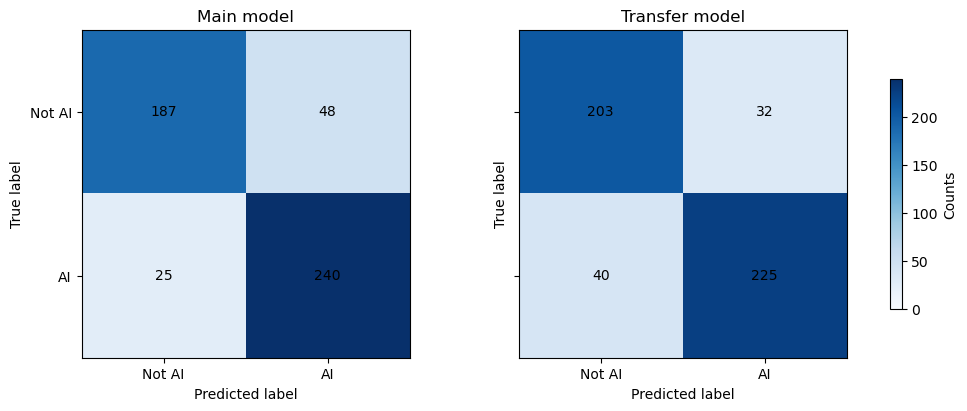

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels = ["Not AI", "AI"]

# compute matrices
confusion_matrix_main = confusion_matrix(y_true, y_test_main_model)
confusion_matrix_transfer = confusion_matrix(y_true, y_test_transfer_model)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True, constrained_layout=True)

# find global max for shared colour scale
vmax = max(confusion_matrix_main.max(), confusion_matrix_transfer.max())

for ax, cm, title in zip(
    axes,
    [confusion_matrix_main, confusion_matrix_transfer],
    ["Main model", "Transfer model"]
):
    im = ax.imshow(cm, interpolation="nearest", vmin=0, vmax=vmax, cmap="Blues")
    ax.set_title(title)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

    # write values inside cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

# shared colourbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.7)
cbar.set_label("Counts")

plt.show()